In [112]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from scipy.stats import ttest_1samp
from collections import defaultdict
from scipy import stats as scipy_stats
from pathlib import Path
import os

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 130)

notebook_path = Path(os.getcwd())
results_path = notebook_path.parent.parent # we should be in /netdeployonnx/client/experiment.ipynb, so we end up in /
figures_path = results_path.parent.parent / "documentation" / "figures"
print(results_path, figures_path)
assert results_path.exists()
assert figures_path.exists(), f"{figures_path} does not exist"
assert str(figures_path).endswith('/_Masterarbeit_SS24/documentation/figures')

/home/vscode/_Masterarbeit_SS24/hannah-env/service /home/vscode/_Masterarbeit_SS24/documentation/figures


In [113]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (5 Layer)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944, # 200_000
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

In [114]:
df = load_results(results_path / "results_npu.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()
df['network_size'] = df['option_network_name'].apply(lambda x:weights[x])
df = df.sort_values(by=['network_size'])
df.columns

Index(['experiment', 'date', 'uJ_per_all', 'uJ_per_inference', 'uJ_per_input_loading', 'uJ_per_weights_loading', 'uW_per_all',
       'uW_per_inference', 'uW_per_input_loading', 'uW_per_weights_loading', 'us_per_all', 'us_per_inference',
       'us_per_input_loading', 'us_per_weights_loading', '_check_model', 'compile_instructions', 'execute', 'layout_transform',
       'total', 'samplepoints', 'option___reflash', 'option_network_name', 'option_read_margin', 'option_read_margin_enable',
       'option_write_neg_voltage_enable', 'option_GCR.pclkdiv.cnnclkdiv', 'option_GCR_pclkdiv.cnnclksel', 'option_layer_count',
       'share_of_weights_loading', 'experiment_idx', 'network_idx', 'network_size'],
      dtype='object')

/tmp/ipykernel_4123859/623962306.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in div

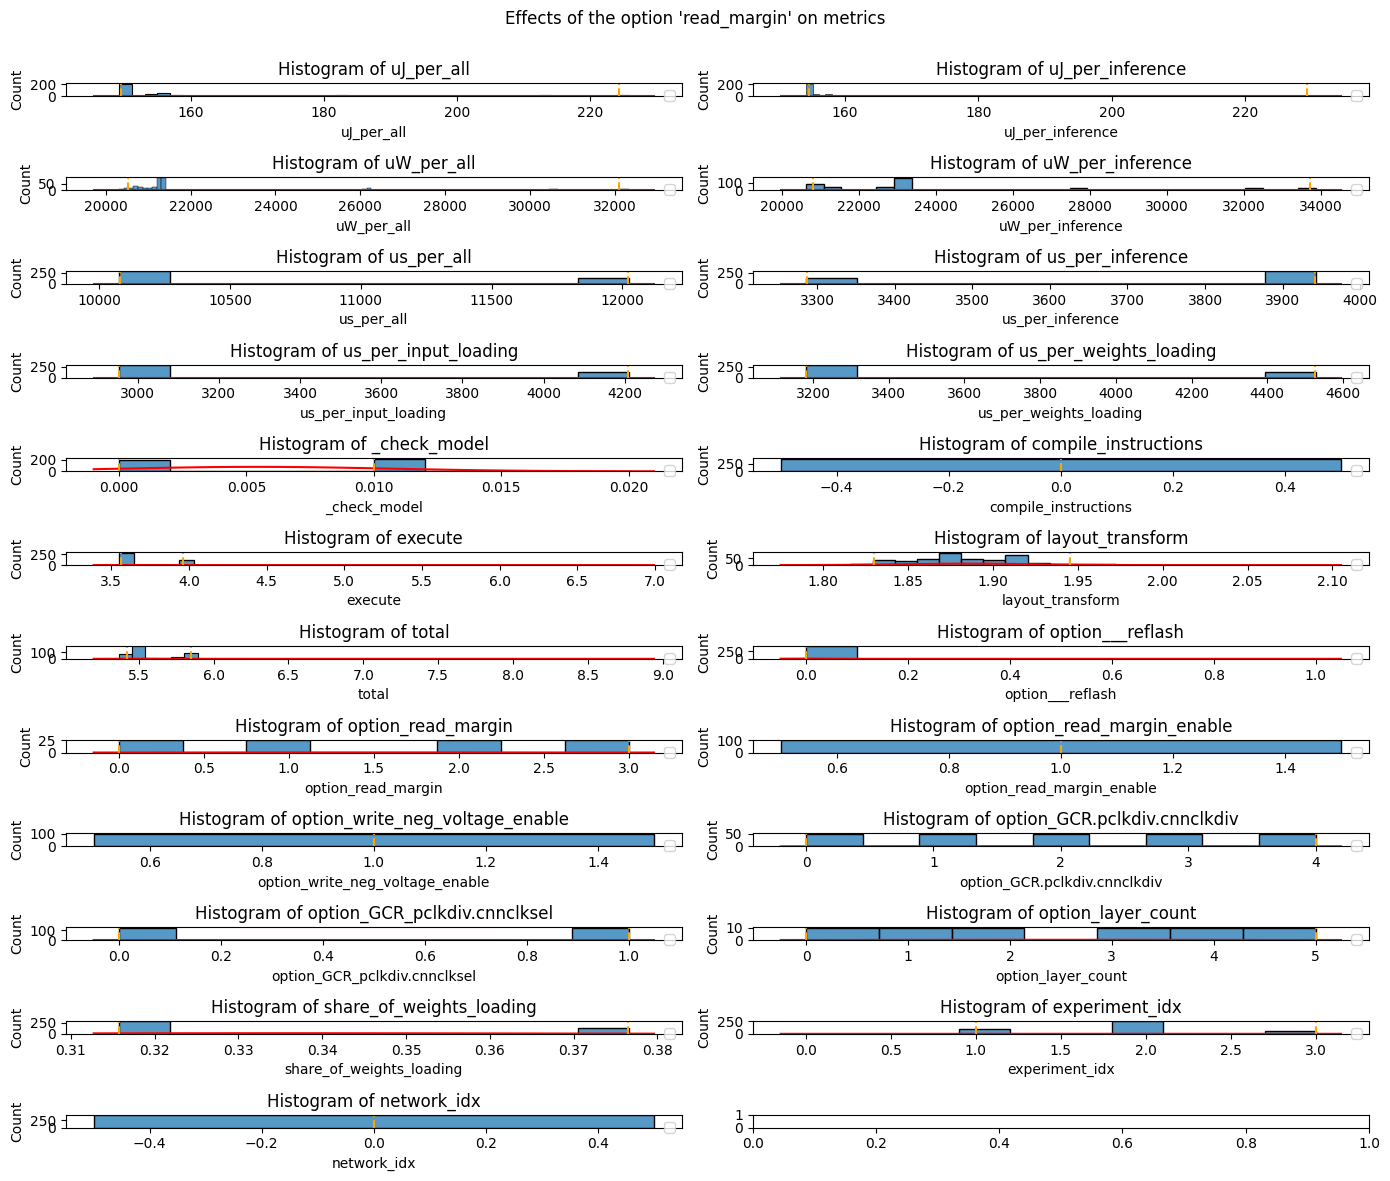

In [115]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


In [116]:
# Create clock frequency mapping dictionaries
clkdiv_dict = {0: 2, 1: 4, 2: 8, 3: 16, 4: 1}  # Changed values based on documentation
clksel_dict = {0: 100, 1: 60}   # This was correct (0:PCLK, 1: ISO)

# Filter for rows that have both clock-related columns
clock_experiments = df_filtered.dropna(subset=['option_GCR.pclkdiv.cnnclkdiv', 
                                             'option_GCR_pclkdiv.cnnclksel'])

# Calculate clock frequency only for relevant experiments
def calculate_clock_freq(row):
    try:
        div = clkdiv_dict[int(row['option_GCR.pclkdiv.cnnclkdiv'])]
        sel = clksel_dict[int(row['option_GCR_pclkdiv.cnnclksel'])]
        return sel / div
    except (KeyError, ValueError):
        return None

# Add clock frequency column
clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
# Add separate columns for clarity
clock_experiments['base_clock'] = clock_experiments['option_GCR_pclkdiv.cnnclksel'].map(clksel_dict)
clock_experiments['divider'] = clock_experiments['option_GCR.pclkdiv.cnnclkdiv'].map(clkdiv_dict)

clock_data = df_filtered.dropna(subset=['option_GCR_pclkdiv.cnnclksel', 'option_GCR.pclkdiv.cnnclkdiv'])
clock_data['base_clock'] = clock_data['option_GCR_pclkdiv.cnnclksel'].map(clksel_dict)
clock_data['divider'] = clock_data['option_GCR.pclkdiv.cnnclkdiv'].map(clkdiv_dict)
clock_data['freq'] = clock_data['base_clock'] / clock_data['divider']

/tmp/ipykernel_4123859/4199425595.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
/tmp/ipykernel_4123859/4199425595.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['base_clock'] = clock_experiments['option_GCR_pclkdiv.cnnclksel'].map(clksel_dict)
/tmp/ipykernel_4123859/4199425595.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [117]:
# Group by clock frequency and calculate mean and std for key metrics

# Analyze for each base clock
for base_clock in [60, 100]:
    subset = clock_experiments[clock_experiments['base_clock'] == base_clock]
    
    print(f"\nAnalysis for {base_clock}MHz base clock:")
    
    # Summary stats by divider
    stats = subset.groupby('divider').agg({
        'us_per_inference': ['mean', 'std'],
        'uW_per_inference': ['mean', 'std'],
        'us_per_all': ['mean', 'std'],
        'uW_per_all': ['mean', 'std'],
    }).round(3)
    
    print("\nSummary by divider:")
    print(stats)
    
    # ANOVA for dividers
    f_stat_time, p_val_time = scipy_stats.f_oneway(
        *[group['us_per_inference'].values for name, group in subset.groupby('divider')]
    )
    
    print(f"\nANOVA p-value for dividers: {p_val_time:.4f}")


Analysis for 60MHz base clock:

Summary by divider:
        us_per_inference        uW_per_inference          us_per_all        uW_per_all         
                    mean    std             mean      std       mean    std       mean      std
divider                                                                                        
1               3286.982  0.325        21041.796  136.350  12019.238  1.044  20759.816  142.269
2               3287.271  0.284        21009.724  260.389  12020.510  0.843  20732.572  268.900
4               3287.156  0.361        21038.348  223.974  12020.262  1.090  20753.156  231.529
8               3287.456  0.319        21022.620  138.689  12021.477  1.112  20742.508  128.746
16              3287.251  0.298        20988.728  208.834  12020.800  0.900  20705.140  204.521

ANOVA p-value for dividers: 0.0000

Analysis for 100MHz base clock:

Summary by divider:
        us_per_inference        uW_per_inference         us_per_all        uW_per_all    

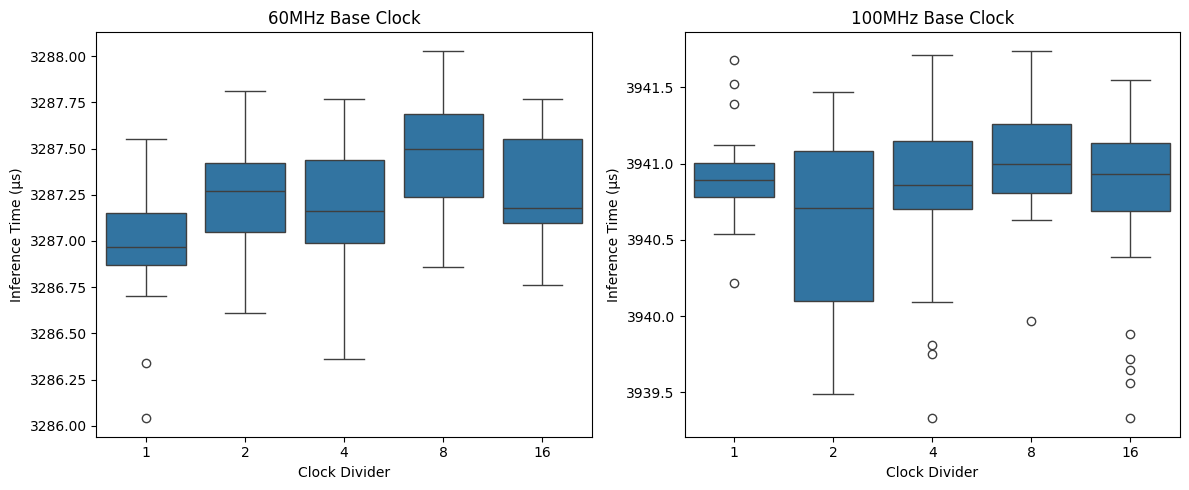


100MHz means by divider:
divider
1     3940.916957
2     3940.588400
4     3940.797600
8     3941.024000
16    3940.733333
Name: us_per_inference, dtype: float64


In [118]:
# Create boxplots separated by base clock to see the divider effects
plt.figure(figsize=(12, 5))

# Plot for 60MHz and 100MHz side by side
plt.subplot(1, 2, 1)
sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 60], 
            x='divider', y='us_per_inference')
plt.title('60MHz Base Clock')
plt.xlabel('Clock Divider')
plt.ylabel('Inference Time (µs)')

plt.subplot(1, 2, 2)
sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 100], 
            x='divider', y='us_per_inference')
plt.title('100MHz Base Clock')
plt.xlabel('Clock Divider')
plt.ylabel('Inference Time (µs)')

plt.tight_layout()
plt.show()

# Print mean values for 100MHz to see if there's any trend despite non-significance
print("\n100MHz means by divider:")
print(clock_experiments[clock_experiments['base_clock'] == 100].groupby('divider')['us_per_inference'].mean())

/tmp/ipykernel_4123859/50172269.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
/tmp/ipykernel_4123859/50172269.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
/tmp/ipykernel_4123859/50172269.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])
/tmp/ipykernel_4123859/50172269.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])


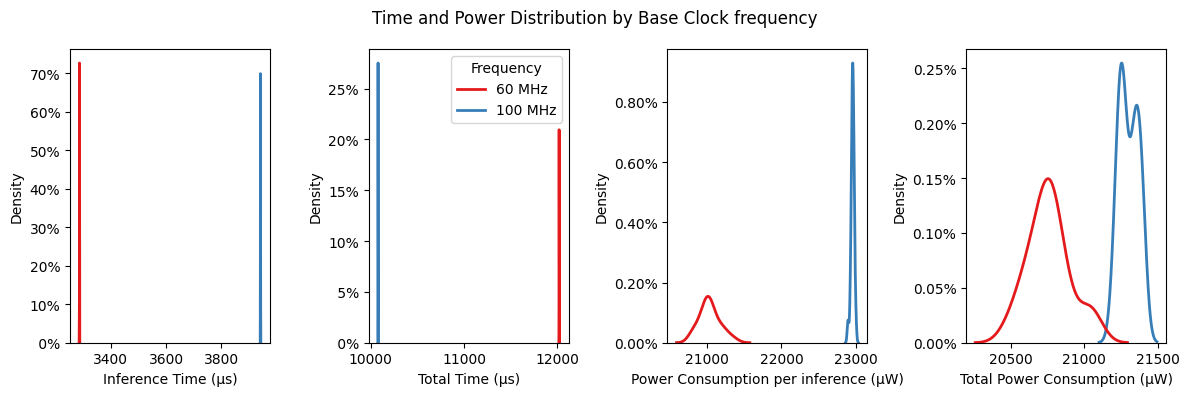

In [119]:
# Set rainbow palette with explicit color mapping
unique_freqs = sorted(clock_data['freq'].unique())
base_clock_data = clock_data[clock_data['freq'].isin([60, 100])]
rainbow_palette = 'Set1' # dict(zip(unique_freqs, sns.color_palette('rainbow', n_colors=len(unique_freqs))))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))

# Time distribution
sns.kdeplot(data=base_clock_data, x='us_per_inference', hue='freq',
           palette=rainbow_palette, ax=ax1, linewidth=2, legend=False)
# ax1.set_title('Time Distribution by Frequency')
ax1.set_xlabel('Inference Time (µs)')
# Time distribution
sns.kdeplot(data=base_clock_data, x='us_per_all', hue='freq',
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=True)
# ax2.set_title('Time Distribution by Frequency')
ax2.set_xlabel('Total Time (µs)')
leg = ax2.get_legend()
leg.set_title("Frequency")
# Get the current labels and format new ones
for t in leg.get_texts():
   t.set_text(f"{float(t.get_text()):2.0f} MHz")

# Power distribution
sns.kdeplot(data=base_clock_data, x='uW_per_inference', hue='freq',
           palette=rainbow_palette, ax=ax3, linewidth=2, legend=False)
# ax3.set_title('Power Distribution by Frequency')
ax3.set_xlabel('Power Consumption per inference (µW)')

# Power distribution
sns.kdeplot(data=base_clock_data, x='uW_per_all', hue='freq',
           palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
# ax4.set_title('Power Distribution by Frequency')
ax4.set_xlabel('Total Power Consumption (µW)')



for ax in [ax1, ax2]:
   ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
for ax in [ax3, ax4]:
   ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])

plt.suptitle('Time and Power Distribution by Base Clock frequency')
plt.tight_layout()
plt.savefig(figures_path / "05_npu_baseclocks.pdf", format='pdf', bbox_inches='tight')
# base_clock_data

In [120]:
# Filter for only base clocks (60 and 100 MHz)
base_clock_data = clock_data[clock_data['freq'].isin([60, 100])]

# Calculate metrics per MHz
base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']

# Print summary statistics
print("Summary statistics by frequency:")
print(base_clock_data.groupby('freq')[['time_per_MHz', 'power_per_MHz']].agg(['mean', 'std']).round(3))

Summary statistics by frequency:
      time_per_MHz        power_per_MHz       
              mean    std          mean    std
freq                                          
60.0        54.783  0.005       350.697  2.273
100.0       39.409  0.003       229.519  0.212


/tmp/ipykernel_4123859/3647561307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
/tmp/ipykernel_4123859/3647561307.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']


/tmp/ipykernel_4123859/4218457567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('divider', ascending=True, inplace=True)
/tmp/ipykernel_4123859/4218457567.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})
/tmp/ipykernel_4123859/4218457567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

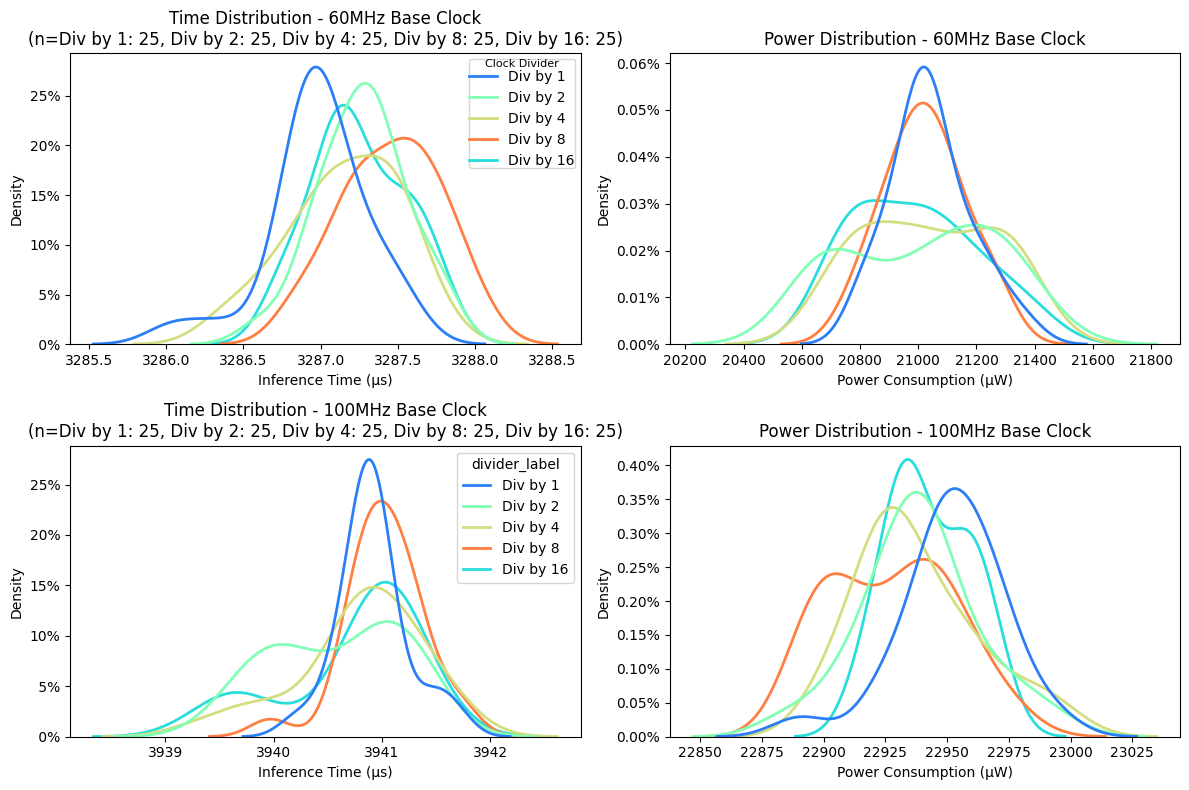

In [125]:
# Create separate dataframes for each base clock
data_60mhz = clock_data[(clock_data['base_clock'] == 60)]
data_100mhz = clock_data[(clock_data['base_clock'] == 100)]

# Add divider labels for each
for df in [data_60mhz, data_100mhz]:
   df.sort_values('divider', ascending=True, inplace=True)
   df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})


# Create figure with subplots for both clock speeds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))


# Set palettes
unique_divs = sorted(data_60mhz['divider_label'].unique())
rainbow_palette = dict(zip(unique_divs, sns.color_palette('rainbow', n_colors=len(unique_divs))))

# 60MHz plots
samples_60 = data_60mhz['divider_label'].value_counts()
title_60 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_60.items()])})'

sns.kdeplot(data=data_60mhz, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax1, linewidth=2)
ax1.set_title(f'Time Distribution - 60MHz Base Clock{title_60}')
ax1.set_xlabel('Inference Time (µs)')

sns.kdeplot(data=data_60mhz, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
ax2.set_title('Power Distribution - 60MHz Base Clock')
ax2.set_xlabel('Power Consumption (µW)')

# 100MHz plots
samples_100 = data_100mhz['divider_label'].value_counts()
title_100 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_100.items()])})'

sns.kdeplot(data=data_100mhz, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax3, linewidth=2)
ax3.set_title(f'Time Distribution - 100MHz Base Clock{title_100}')
ax3.set_xlabel('Inference Time (µs)')

sns.kdeplot(data=data_100mhz, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title('Power Distribution - 100MHz Base Clock')
ax4.set_xlabel('Power Consumption (µW)')


for ax in [ax1, ax3]:
   ax.set_yticklabels([f"{float(y)*100:2.0f}%" for y in ax.get_yticks()])
for ax in [ax2, ax4]:
   ax.set_yticklabels([f"{float(y)*100:2.2f}%" for y in ax.get_yticks()])

# Modify legend
leg = ax1.get_legend()
leg.set_title("Clock Divider")
leg._fontsize = 8
leg.get_title().set_fontsize(8)
leg._legend_box.sep = 1
leg._legend_box.pad = 0.1

plt.tight_layout()
plt.savefig(figures_path / "05_npu_clockdividers.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_4123859/2880250206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('divider', ascending=True, inplace=True)
/tmp/ipykernel_4123859/2880250206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})
/tmp/ipykernel_4123859/2880250206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

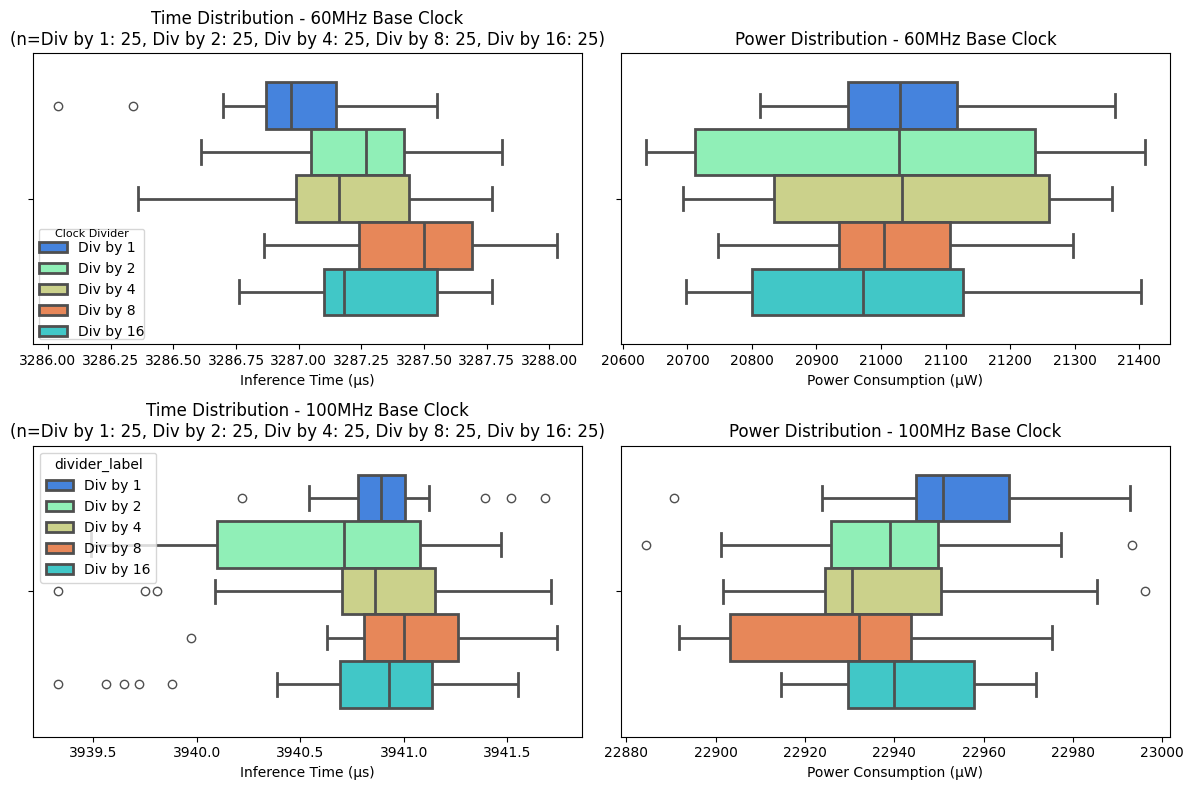

In [126]:
# Create separate dataframes for each base clock
data_60mhz = clock_data[(clock_data['base_clock'] == 60)]
data_100mhz = clock_data[(clock_data['base_clock'] == 100)]

# Add divider labels for each
for df in [data_60mhz, data_100mhz]:
   df.sort_values('divider', ascending=True, inplace=True)
   df['divider_label'] = df['divider'].map({1: 'Div by 1', 2: 'Div by 2', 4: 'Div by 4', 8: 'Div by 8', 16: 'Div by 16'})


# Create figure with subplots for both clock speeds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Set palettes
unique_divs = sorted(data_60mhz['divider_label'].unique())
rainbow_palette = dict(zip(unique_divs, sns.color_palette('rainbow', n_colors=len(unique_divs))))

# 60MHz plots
samples_60 = data_60mhz['divider_label'].value_counts()
title_60 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_60.items()])})'

sns.boxplot(data=data_60mhz, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax1, linewidth=2)
ax1.set_title(f'Time Distribution - 60MHz Base Clock{title_60}')
ax1.set_xlabel('Inference Time (µs)')

sns.boxplot(data=data_60mhz, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
ax2.set_title('Power Distribution - 60MHz Base Clock')
ax2.set_xlabel('Power Consumption (µW)')

# 100MHz plots
samples_100 = data_100mhz['divider_label'].value_counts()
title_100 = f'\n(n={", ".join([f"{div}: {count}" for div, count in samples_100.items()])})'

sns.boxplot(data=data_100mhz, x='us_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax3, linewidth=2)
ax3.set_title(f'Time Distribution - 100MHz Base Clock{title_100}')
ax3.set_xlabel('Inference Time (µs)')

sns.boxplot(data=data_100mhz, x='uW_per_inference', hue='divider_label',
           palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title('Power Distribution - 100MHz Base Clock')
ax4.set_xlabel('Power Consumption (µW)')

# Modify legend
leg = ax1.get_legend()
leg.set_title("Clock Divider")
leg._fontsize = 8
leg.get_title().set_fontsize(8)
leg._legend_box.sep = 1
leg._legend_box.pad = 0.1

plt.tight_layout()
plt.savefig(figures_path / "05_npu_clockdividers_hist.pdf", format='pdf', bbox_inches='tight')

/tmp/ipykernel_4123859/1539740649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)
/tmp/ipykernel_4123859/1539740649.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels([f'{y}' for y in y3_ticks])
/tmp/ipykernel_4123859/1539740649.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels([f'{y}' for y in y4_ticks])


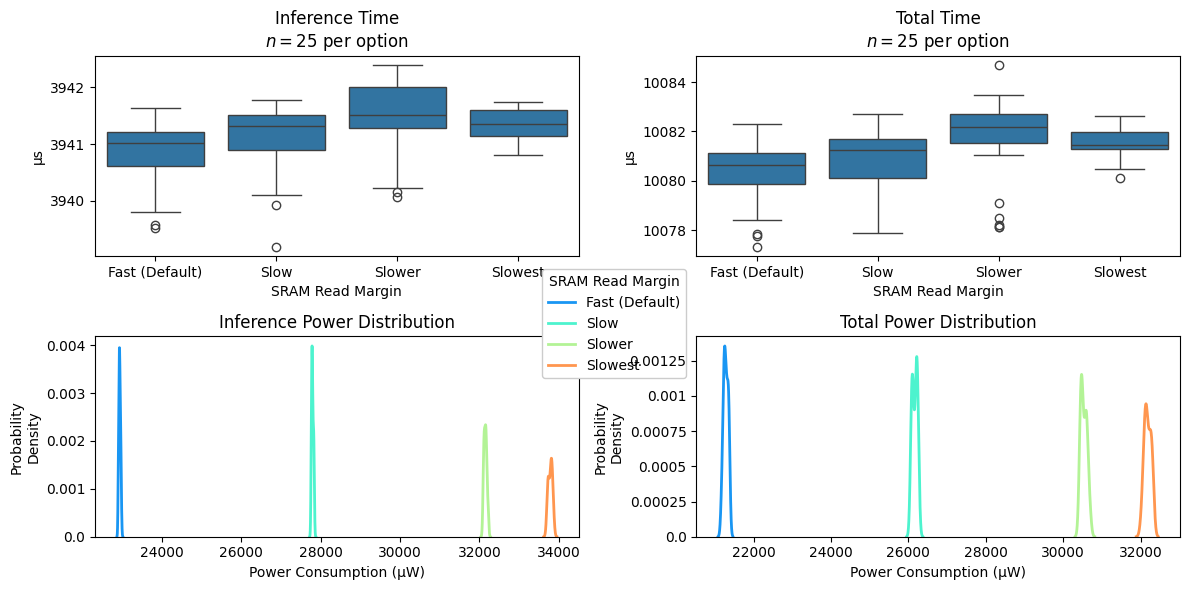

In [127]:
margin_labels = {
   0: 'Slowest',
   1: 'Slower',
   2: 'Slow',
   3: 'Fast (Default)',
}

margin_data = df_filtered.dropna(subset=['option_read_margin'])
margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)

samples_per_option = margin_data['read_margin'].value_counts()
title_suffix = f'\n$n={min([]+[x for x in samples_per_option])}$ per option'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

# Time boxplots
sns.boxplot(data=margin_data, x='read_margin', y='us_per_inference', ax=ax1)
ax1.set_title(f'Inference Time{title_suffix}')
ax1.set_ylabel('µs')
ax1.set_xlabel('SRAM Read Margin')

sns.boxplot(data=margin_data, x='read_margin', y='us_per_all', ax=ax2)
ax2.set_title(f'Total Time{title_suffix}')
ax2.set_ylabel('µs')
ax2.set_xlabel('SRAM Read Margin')

# Power distributions
unique_margins = sorted(margin_data['read_margin'].unique())
rainbow_palette = dict(zip(unique_margins, sns.color_palette('rainbow', n_colors=len(unique_margins))))

n_samples = len(margin_data)

# Create KDE plots and save the legend handles from one plot
kde1 = sns.kdeplot(data=margin_data, x='uW_per_inference', hue='read_margin',
                  palette=rainbow_palette, ax=ax3, linewidth=2, legend=True)
ax3.set_title('Inference Power Distribution')
ax3.set_xlabel('Power Consumption (µW)')


# Add a single legend at the bottom center
handles, labels = ax3.get_legend_handles_labels()
y3_ticks = ax3.get_yticks()
ax3.set_yticklabels([f'{y}' for y in y3_ticks])
ax3.set_ylabel('Probability\nDensity')

kde2 = sns.kdeplot(data=margin_data, x='uW_per_all', hue='read_margin', 
                  palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title('Total Power Distribution')
ax4.set_xlabel('Power Consumption (µW)')
y4_ticks = ax4.get_yticks()
ax4.set_yticklabels([f'{y}' for y in y4_ticks])
ax4.set_ylabel('Probability\nDensity')


# Get and modify legend
leg = ax3.get_legend()
leg.set_bbox_to_anchor((0.45, 0.35), transform=fig.transFigure) # Center of figure
leg.set_title('SRAM Read Margin')
leg.set_zorder(1000)  # Set high z-index to show legend on top
leg.get_frame().set_alpha(1.0)  # Make legend background fully opaque
leg.get_frame().set_facecolor('white')  # Ensure white background

plt.subplots_adjust(wspace=-0.5, right=0.95, left=0.05)
plt.tight_layout()

plt.savefig(figures_path / "05_npu_read_margin.pdf", format='pdf', bbox_inches='tight')

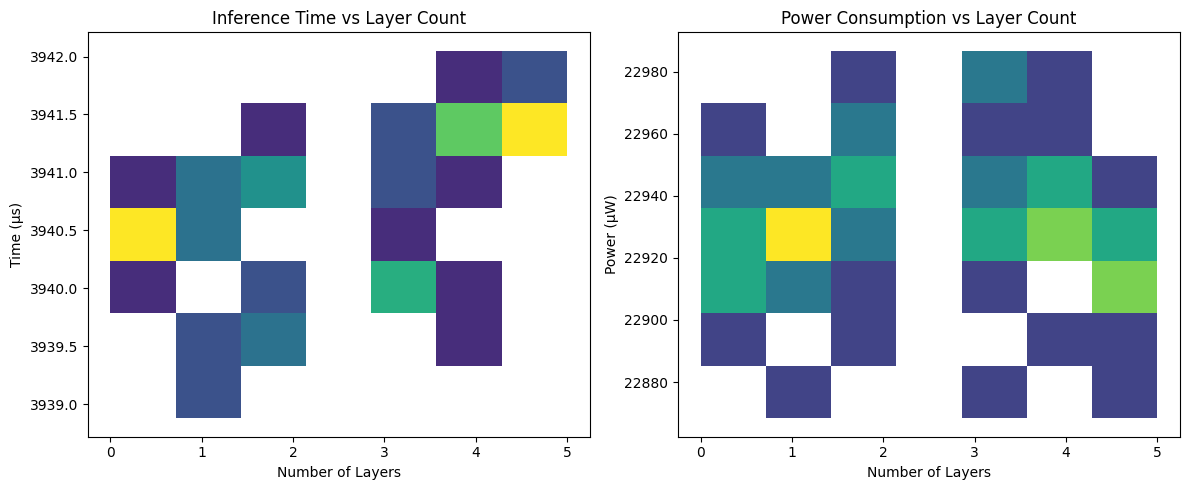

In [128]:
# Create subplots for time and power vs layer count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time plot
sns.histplot(data=df_filtered, x='option_layer_count', y='us_per_inference', 
            ax=ax1, cmap='viridis')
ax1.set_title('Inference Time vs Layer Count')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Time (µs)')

# Power plot 
sns.histplot(data=df_filtered, x='option_layer_count', y='uW_per_inference',
            ax=ax2, cmap='viridis')
ax2.set_title('Power Consumption vs Layer Count')
ax2.set_xlabel('Number of Layers')
ax2.set_ylabel('Power (µW)')

plt.tight_layout()
plt.show()

# Print unique layer counts and their frequencies
# print("\nLayer count distribution:")
# print(df_filtered['option_layer_count'].value_counts().sort_index())